In [1]:
# Check the data
import pandas as pd
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
station="28079004"
df = pd.read_csv(f"/home/sebas/data/air_qual_aemet/{station}.csv",sep=";")
# Limiting Date
df = df[df["DATE"]<"2020-01-01"]

tdf = df[["DATE","SPA.NO2"]].copy()
tdf.columns = ["DATE","NO2"]
tdf["NO2"]=np.log1p(tdf["NO2"])

from statsmodels.tsa.seasonal import seasonal_decompose
stl = seasonal_decompose(tdf["NO2"], model="additive",period=24)
tdf["NO2"]=tdf["NO2"]-stl.seasonal
tdf["trend"]=stl.trend

horizon=13

tdf["trend_norm"]=tdf["trend"].shift(horizon)

# We remove the trend and keep past values
for h in reversed(np.arange(0,3*24)):
    if h>horizon:
        tdf[f"NO2 - {h}"]=(tdf["NO2"].shift(h)-tdf["trend_norm"]).copy()

tdf=tdf.dropna()

cols = tdf.columns[tdf.columns.str.contains("NO2 -")]
X = tdf[cols].copy()
y = tdf[["NO2"]].copy()

In [3]:
X.head()

NO2 - 71  NO2 - 70  NO2 - 69  NO2 - 68  NO2 - 67  NO2 - 66  NO2 - 65  \
71  0.313712  0.391156  0.230022  0.264430  0.033721  0.399788  0.200565   
72  0.447698  0.286564  0.320972  0.090263  0.456330  0.257107  0.362316   
73  0.350767  0.385175  0.154465  0.520533  0.321310  0.426519  0.790285   
74  0.445592  0.214882  0.580949  0.381726  0.486935  0.850701  0.511572   
75  0.264408  0.630475  0.431252  0.536461  0.900227  0.561098  0.133508   

    NO2 - 64  NO2 - 63  NO2 - 62  ...  NO2 - 23  NO2 - 22  NO2 - 21  NO2 - 20  \
71  0.305774  0.669540  0.330411  ...  1.136071  0.661447  0.718869  0.454474   
72  0.726082  0.386953 -0.040637  ...  0.717989  0.775411  0.511016  0.484917   
73  0.451156  0.023566  0.247453  ...  0.839614  0.575219  0.549120  0.738786   
74  0.083983  0.307869 -0.280719  ...  0.635635  0.609536  0.799203  0.996093   
75  0.357395 -0.231193 -0.413073  ...  0.659062  0.848728  1.045618  1.079326   

    NO2 - 19  NO2 - 18  NO2 - 17  NO2 - 16  NO2 - 15  NO2 - 14  
71  0.428375  0.618041  0.814931  0.848639  0.785800 -0.059054  
72  0.674583  0.871473  0.905181  0.842342 -0.002512 -0.342918  
73  0.935676  0.969384  0.906545  0.061691 -0.278715 -0.531217  
74  1.029800  0.966961  0.122108 -0.218298 -0.470800 -0.495830  
75  1.016487  0.171633 -0.168773 -0.421275 -0.446305 -0.368621  

[5 rows x 58 columns]

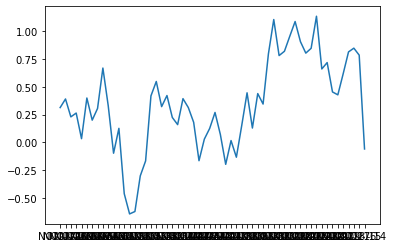

In [352]:
plt.plot(X.iloc[0].T)

In [353]:
X.shape

(56907, 58)

In [394]:
TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

X_train=X[X.index<=TRAIN_SPLIT].copy()
X_test=X[X.index>TRAIN_SPLIT].copy()
y_train = y[X.index<=TRAIN_SPLIT].copy()
y_test = y[X.index>TRAIN_SPLIT].copy()

In [395]:
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.FloatTensor(X_train.values).to(device)
X_test = torch.FloatTensor(X_test.values).to(device)
y_train = torch.FloatTensor(y_train.values).to(device)
y_test= torch.FloatTensor(y_test.values).to(device)

In [356]:
# batch size = 56811
# seq length = 154
# N Features = 1

In [357]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [396]:
from torch.autograd import Variable

class Net(nn.Module):
  def __init__(self):
    self.input_size = 1
    self.output_size=1
    self.hidden_dim=64
    self.n_layers=1

    super(Net,self).__init__() 
    self.lstm = nn.LSTM(self.input_size, self.hidden_dim, self.n_layers, batch_first=True)
    self.fc = nn.Linear(self.hidden_dim, self.output_size)


  def forward(self,x):
    h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(device)
    c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(device)
    
    out, (hidden,_) = self.lstm(x,(h_0, c_0))
    
    h_out = hidden[-1].view(-1, self.hidden_dim)
        
    # get final output 
    output = self.fc(h_out)
    
    return output

net = Net() 
net.to(device)

Net(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [397]:
X_train.shape

torch.Size([39400, 58])

In [398]:
X_train.shape
# Must be:[batch_size, seq_len, input_size]

torch.Size([39400, 58])

In [399]:
#128 154 64

#1  128 64

In [400]:
net(X_train[:128,:].reshape([128, 58,1])).cpu().detach().numpy().shape

(128, 1)

In [401]:
from sklearn.metrics import mean_squared_error

In [402]:
# https://github.com/harryliew/COCOB-optimizer/blob/master/cocob_bp.py

import torch.optim as optim
import torch

###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8):
        
        self._alpha = alpha
        self.epsilon = epsilon
        defaults = dict(alpha=alpha, epsilon=epsilon)
        super(COCOBBackprop, self).__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
        
                grad = p.grad.data
                state = self.state[p]
                
                if len(state) == 0:
                    state['gradients_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['grad_norm_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['L'] = self.epsilon * torch.ones_like(p.data).cuda().float()
                    state['tilde_w'] = torch.zeros_like(p.data).cuda().float()
                    state['reward'] = torch.zeros_like(p.data).cuda().float()
                    
                gradients_sum = state['gradients_sum']
                grad_norm_sum = state['grad_norm_sum']
                tilde_w = state['tilde_w']
                L = state['L']
                reward = state['reward']
                
                zero = torch.cuda.FloatTensor([0.])
                
                L_update = torch.max(L, torch.abs(grad))
                gradients_sum_update = gradients_sum + grad
                grad_norm_sum_update = grad_norm_sum + torch.abs(grad)
                reward_update = torch.max(reward - grad * tilde_w, zero)
                new_w = -gradients_sum_update/(L_update * (torch.max(grad_norm_sum_update + L_update, self._alpha * L_update)))*(reward_update + L_update)
                p.data = p.data - tilde_w + new_w
                tilde_w_update = new_w
                
                state['gradients_sum'] = gradients_sum_update
                state['grad_norm_sum'] = grad_norm_sum_update
                state['L'] = L_update
                state['tilde_w'] = tilde_w_update
                state['reward'] = reward_update

        return loss


In [403]:
criterion = nn.MSELoss(reduction='sum')
optimizer = COCOBBackprop(net.parameters())
batch_size = 32
epochs = 6

train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

for j in range(epochs):
    m_loss = []
    for i,batch in enumerate(train_loader):
        train_features, train_labels = batch
        y_hat = net.forward(train_features.reshape([len(train_features), 58,1])).to(device)
        loss = criterion(y_hat, train_labels)
        m_loss.append(loss.detach().cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
    predictions=np.array([])
    for i,batch in enumerate(test_loader):
        test_b = batch[0]
        predictions = np.concatenate([predictions,net(test_b.reshape([len(test_b), 58,1])).cpu().reshape(-1).detach().numpy()])
    #loss_arr.append(np.mean(m_loss))
    #val_loss_arr.append(np.sqrt(mean_squared_error(predictions,y_test.cpu())))
    print(f'Epoch: {j} Loss: {np.mean(m_loss)} Val Loss: {np.sqrt(mean_squared_error(predictions,y_test.cpu()))}')

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch: 0 Loss: 11.220789909362793 Val Loss: 0.6711815426336336


/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch: 1 Loss: 8.438915252685547 Val Loss: 0.6758005737435986


/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch: 2 Loss: 8.319202423095703 Val Loss: 0.6912014042088487


/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch: 3 Loss: 8.247286796569824 Val Loss: 0.7062880736040309


/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch: 4 Loss: 8.219721794128418 Val Loss: 0.6883466963315177


/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch: 5 Loss: 8.186166763305664 Val Loss: 0.6845761585193227


In [385]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

fulls = len(X_train.cpu()[0])
mids = int(len(X_train.cpu()[0])/2)

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__() 
    self.whole = nn.Sequential(
        nn.Linear(fulls,2*fulls),
        nn.ReLU(),
        nn.LayerNorm(2*fulls),
        nn.Linear(2*fulls,mids),
        nn.ReLU(),
        nn.LayerNorm(mids),
        nn.Linear(mids,1)
        )

  def forward(self,x):
    x = self.whole(x)
    return x

net = Net() 
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0.00001)
#optimizer = COCOBBackprop(net.parameters())

loss_arr = []
val_loss_arr = []
epochs = 6

train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=256, shuffle=True)

for j in range(epochs):
  m_loss = []
  for i,batch in enumerate(train_loader):
    train_features, train_labels = batch
    y_hat = net.forward(train_features).to(device)
    loss = criterion(y_hat, train_labels)
    m_loss.append(loss.detach().cpu().numpy())
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = net(X_test).cpu().reshape(-1).detach().numpy()
  loss_arr.append(np.mean(m_loss))
  val_loss_arr.append(np.sqrt(mean_squared_error(predictions,y_test.cpu())))
  print(f'Epoch: {j} Loss: {np.mean(m_loss)} Val Loss: {np.sqrt(mean_squared_error(predictions,y_test.cpu()))}')

Epoch: 0 Loss: 196.97494506835938 Val Loss: 0.5591471195220947
Epoch: 1 Loss: 67.267822265625 Val Loss: 0.546899676322937
Epoch: 2 Loss: 63.90300369262695 Val Loss: 0.5468499660491943
Epoch: 3 Loss: 61.83918380737305 Val Loss: 0.5359558463096619
Epoch: 4 Loss: 60.33985137939453 Val Loss: 0.5396912097930908
Epoch: 5 Loss: 59.242061614990234 Val Loss: 0.5333669781684875


In [386]:
import lightgbm as lgb

lgbmodel = lgb.LGBMRegressor(n_estimators=1600,
                                    random_state=2020,
                                  max_depth=6)

from sklearn.metrics import mean_squared_error
lgbmodel.fit(X_train.cpu(),y_train.cpu())
predictions = lgbmodel.predict(X_test.cpu())
np.sqrt(mean_squared_error(predictions,y_test.cpu()))

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.524876815724352

In [392]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

n_channels = 64
k_size = 3
n_dil = 2

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__() 
    self.features = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=n_channels, kernel_size=k_size, padding=1),
        nn.MaxPool1d(2),
        nn.ReLU(),
    )
    
    self.regressor = nn.Sequential(
        nn.LayerNorm(n_channels*29),
        nn.Linear(n_channels*29,200),
        nn.ReLU(),
        nn.LayerNorm(200),
        nn.Linear(200,1)
    )

  def forward(self,x):
    x = self.features(x)
    #print(x.shape)
    x = x.view(-1,n_channels*x.shape[2])
    return self.regressor(x)

net = Net() 
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = COCOBBackprop(net.parameters())

loss_arr = []
val_loss_arr = []
epochs = 10

X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train_loader = DataLoader(train, batch_size=128, shuffle=True)

for j in range(epochs):
    m_loss = []
    for i,batch in enumerate(train_loader):
      train_features, train_labels = batch
      y_hat = net.forward(train_features)
      loss = criterion(y_hat, train_labels)
      m_loss.append(loss.cpu().detach().numpy())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss_arr.append(np.mean(m_loss))

    X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
    predictions = net(X_test_gf).cpu().reshape(-1).detach().numpy()
    val_loss_arr.append(np.sqrt(mean_squared_error(predictions,y_test.cpu())))

    print(f'Epoch: {j} Loss: {np.mean(m_loss)} Val Loss: {np.sqrt(mean_squared_error(predictions,y_test.cpu()))}')


Epoch: 0 Loss: 42.74711990356445 Val Loss: 0.5314860939979553
Epoch: 1 Loss: 31.456073760986328 Val Loss: 0.5324621796607971
Epoch: 2 Loss: 30.68372344970703 Val Loss: 0.5161141753196716
Epoch: 3 Loss: 30.126129150390625 Val Loss: 0.529841423034668
Epoch: 4 Loss: 29.706462860107422 Val Loss: 0.5315541625022888
Epoch: 5 Loss: 29.397403717041016 Val Loss: 0.5171089172363281
Epoch: 6 Loss: 29.298276901245117 Val Loss: 0.5103262662887573
Epoch: 7 Loss: 29.208293914794922 Val Loss: 0.5163974761962891
Epoch: 8 Loss: 28.884695053100586 Val Loss: 0.5162995457649231
Epoch: 9 Loss: 28.63861846923828 Val Loss: 0.5253218412399292
